Class distribution of the entire training set:  [4666 5362 1304 2159 1937  572]


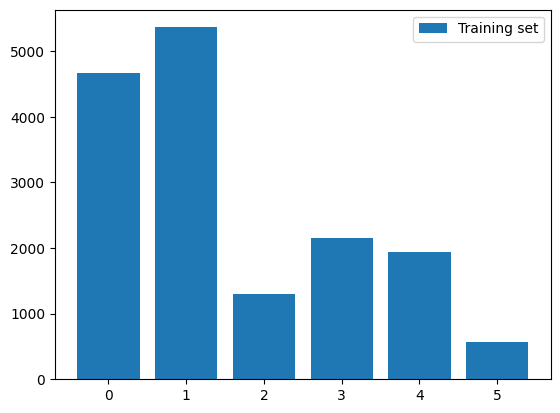

In [3]:
import numpy as np
# load the training features and labels
training_features = np.load('models/training_features-data-clean.npy')
training_labels = np.load('models/training_labels-data-clean.npy')


# compute the class distribution of the entire training set
training_class_distribution = np.bincount(training_labels)

# compare the class distributions
print('Class distribution of the entire training set: ', training_class_distribution)

# visualize plots of the class distributions
import matplotlib.pyplot as plt
plt.bar(np.arange(len(training_class_distribution)), training_class_distribution, label='Training set')
plt.legend()
plt.show()


The data that have labels 2, 3, 4 and 5 especially need to be augmented. The data that have labels 0 and 1 are already well represented in the training set.

In [4]:
from sklearn.utils import resample

majority_class_count = np.max(training_class_distribution)

upsampled_training_features = []
upsampled_training_labels = []

for label in np.unique(training_labels):
    class_indices = np.where(training_labels == label)[0]
    oversampled_class_indices = resample(class_indices, replace=True, n_samples=majority_class_count, random_state=0)

    upsampled_training_features.append(training_features[oversampled_class_indices])
    upsampled_training_labels.append(training_labels[oversampled_class_indices])

upsampled_training_features = np.concatenate(upsampled_training_features)
upsampled_training_labels = np.concatenate(upsampled_training_labels)


Choose a suitable dataset for grid search

Class distribution of the entire training set:  [5362 5362 5362 5362 5362 5362]
Class distribution of the subset:  [530 536 574 537 544 496]


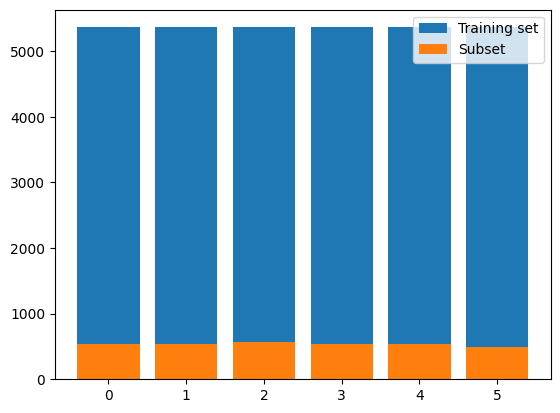

In [5]:
subset_size = 0.1
# split the training data into a subset and the remaining data
subset_indices = np.random.choice(len(upsampled_training_features), int(subset_size * len(upsampled_training_features)), replace=False)
subset_features = upsampled_training_features[subset_indices]

# compute the class distribution of the subset
subset_labels = upsampled_training_labels[subset_indices]
subset_class_distribution = np.bincount(subset_labels)

# compute the class distribution of the entire training set
training_class_distribution = np.bincount(upsampled_training_labels)

# compare the class distributions
print('Class distribution of the entire training set: ', training_class_distribution)
print('Class distribution of the subset: ', subset_class_distribution)

# visualize plots of the class distributions
import matplotlib.pyplot as plt
plt.bar(np.arange(len(training_class_distribution)), training_class_distribution, label='Training set')
plt.bar(np.arange(len(subset_class_distribution)), subset_class_distribution, label='Subset')
plt.legend()
plt.show()

Perform grid search

In [6]:
from datetime import datetime
from sklearn.svm import SVC

# SVM classification
parameters = {
    'C': [ 1, 50, 75],
    'gamma': [1, 0.01, 0.001 , 'scale'],
    'kernel': ['rbf', 'poly', 'sigmoid']
}
# Construct the final SVM
final_svm_classifier = SVC()
# Perform grid search to find the best parameters
from sklearn.model_selection import GridSearchCV
print('Begin grid search' + ' - ' + str(datetime.now()))
grid_search = GridSearchCV(final_svm_classifier, parameters, cv=5)
print('Training SVM to find the best hyperparameters' + ' - ' + str(datetime.now()))
grid_search.fit(subset_features, subset_labels)
print('Finished looking for best hyperparameters' + ' - ' + str(datetime.now()))
print('Best hyperparameters: ', grid_search.best_params_)


Begin grid search - 2023-06-13 14:08:59.193413
Training SVM to find the best hyperparameters - 2023-06-13 14:08:59.193413
Finished looking for best hyperparameters - 2023-06-13 14:19:21.144833
Best hyperparameters:  {'C': 50, 'gamma': 0.01, 'kernel': 'rbf'}


Train the final SVM

In [7]:
# Use the best model for prediction
final_svm_classifier = grid_search.best_estimator_
# use the already existing model
print('Begin training final SVM model' + ' - ' + str(datetime.now()))
final_svm_classifier.fit(upsampled_training_features, upsampled_training_labels)
print('Finished training final SVM model' + ' - ' + str(datetime.now()))

Begin training final SVM model - 2023-06-13 14:19:34.370411
Finished training final SVM model - 2023-06-13 14:24:29.540549


Predict with the final SVM

Class distribution of the test set:  [581 695 159 275 224  66]


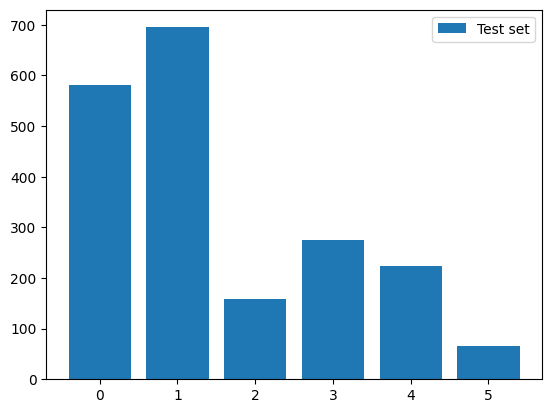

In [9]:
all_test_features = np.load('models/test_features-clean-data.npy')
test_labels = np.load('models/test_labels-clean-data.npy')

# compute the class distribution of the test set
test_class_distribution = np.bincount(test_labels)

# compare the class distributions
print('Class distribution of the test set: ', test_class_distribution)

# visualize plots of the class distributions
import matplotlib.pyplot as plt
plt.bar(np.arange(len(test_class_distribution)), test_class_distribution, label='Test set')
plt.legend()
plt.show()



Class distribution of the upsampled test set:  [695 695 695 695 695 695]


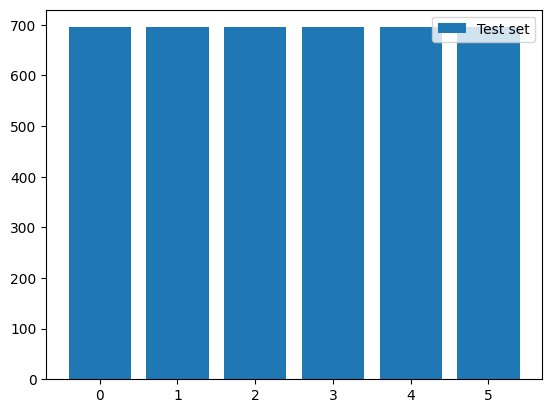

In [10]:
# perform oversampling on the test set
majority_class_count = np.max(test_class_distribution)

upsampled_test_features = []
upsampled_test_labels = []

for label in np.unique(test_labels):
    class_indices = np.where(test_labels == label)[0]
    oversampled_class_indices = resample(class_indices, replace=True, n_samples=majority_class_count, random_state=0)

    upsampled_test_features.append(all_test_features[oversampled_class_indices])
    upsampled_test_labels.append(test_labels[oversampled_class_indices])

upsampled_test_features = np.concatenate(upsampled_test_features)
upsampled_test_labels = np.concatenate(upsampled_test_labels)

# see the class distribution of the upsampled test set
upsampled_test_class_distribution = np.bincount(upsampled_test_labels)
print('Class distribution of the upsampled test set: ', upsampled_test_class_distribution)

# visualize plots of the class distributions
import matplotlib.pyplot as plt
plt.bar(np.arange(len(upsampled_test_class_distribution)), upsampled_test_class_distribution, label='Test set')
plt.legend()
plt.show()


In [11]:
from sklearn.metrics import classification_report
# load the test features and labels
print('Begin prediction' + ' - ' + str(datetime.now()))
predictions = final_svm_classifier.predict(upsampled_test_features)
print('Finish prediction' + ' - ' + str(datetime.now()))
report = classification_report(upsampled_test_labels, predictions)
print(report)

Begin prediction - 2023-06-13 16:36:18.740048
Finish prediction - 2023-06-13 16:37:30.928161
              precision    recall  f1-score   support

           0       0.42      0.62      0.50       695
           1       0.44      0.71      0.55       695
           2       0.67      0.42      0.52       695
           3       0.61      0.51      0.56       695
           4       0.49      0.53      0.51       695
           5       0.77      0.27      0.41       695

    accuracy                           0.51      4170
   macro avg       0.57      0.51      0.51      4170
weighted avg       0.57      0.51      0.51      4170

